# **Clone the repository and Install dependencies**

In [1]:
!pip install hdf5storage
!pip install numpy==1.23.5
!git clone https://github.com/adityajn105/brain-tumor-segmentation-unet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 86.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
woodwork 0.31.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
featuretools 1.

# **Download the data and Convert Data** 

In [2]:
!bash /kaggle/working/brain-tumor-segmentation-unet/download_data.sh
!python /kaggle/working/brain-tumor-segmentation-unet/mat_to_numpy.py brain_tumor_dataset/

3064
[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in brain_tumor_dataset/


# **Necessary imports**

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gc

import tensorflow as tf
from keras.losses import binary_crossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.saving import register_keras_serializable

from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Precision, Recall

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model


2025-05-02 13:12:50.954214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746191571.110600      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746191571.162442      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Load the data**

In [4]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

##Load images, labels, masks
labels = np.load('brain_tumor_dataset/labels.npy')
images = np.clip( (np.load('brain_tumor_dataset/images.npy')/12728),0,1)
masks = np.load('brain_tumor_dataset/masks.npy')*1
print(labels.shape)
print(images.shape)
print(masks.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)


# **Adding Channel Dimension for Image and Mask Arrays**
This section expands the dimensions of the images and masks arrays to ensure compatibility with deep learning models.

In [ ]:
from skimage.transform import resize
img_size_ori = 512
img_size_target = 128

images = np.expand_dims(images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

images = np.array([ downsample(image) for image in images ])
masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

print(images.shape)
print(masks.shape)

(3064, 128, 128, 1)
(3064, 128, 128, 1)


# **Class distribution of tumor types**

[ 708 1426  930]


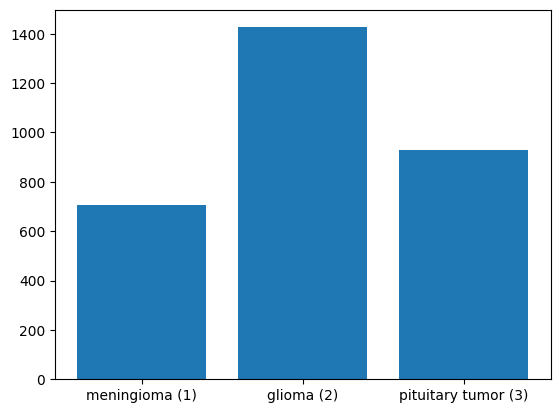

In [6]:
classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

# **Visualizing MRI scans and Masks**

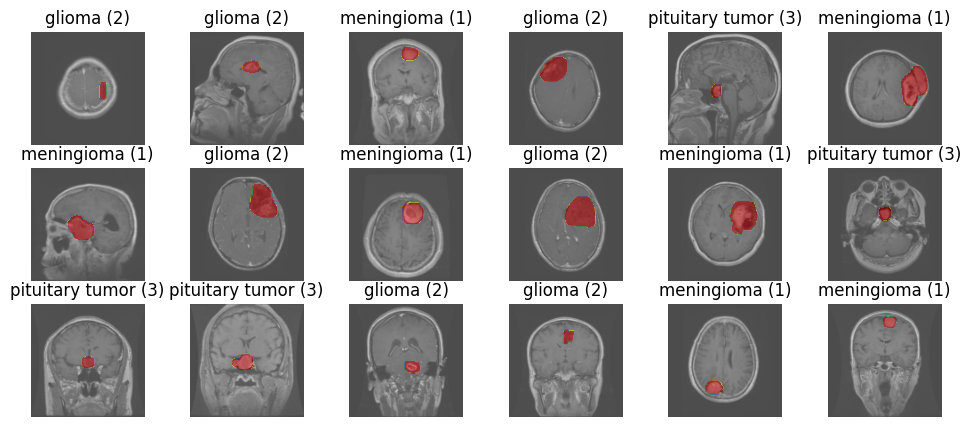

In [7]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( np.squeeze(images[idx],axis=-1), cmap='gray')
    plt.imshow( np.squeeze(np.ones_like(masks[idx])-masks[idx],axis=-1), alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

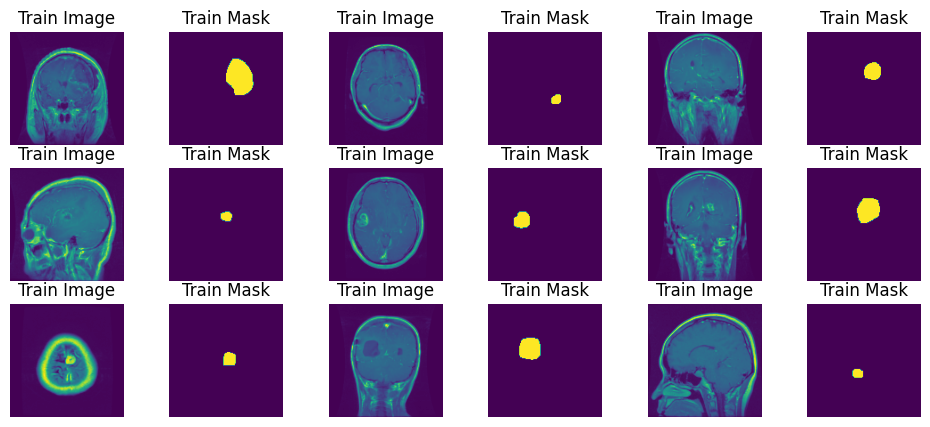

In [8]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( images.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(images[idx],axis=-1))
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow( np.squeeze(masks[idx],axis=-1))
  plt.title("Train Mask")
  plt.axis('off')

# **Preparing Data for Model Training**


1. Original Data: 3064 MRI Scans, 3064 Masks, 3064 labels
2. Train Test Split Initial: 80% for train and val, 20% for test
3. Train Test Split Final (80%): 80% Training and 20% Validation Set



In [9]:
# Ensure your labels are a numpy array or list of labels
labels = np.array(labels)  # labels for classification (e.g., meningioma, glioma, pituitary tumor)

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [10]:
X_train, X_test, Y_train, Y_test, train_labels, test_labels = train_test_split(
    images, masks, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)
del images
del masks
gc.collect()

35219

In [11]:
# Further split the training data into training and validation sets (80% train, 20% validation)
X_train, X_val, Y_train, Y_val, train_labels, val_labels = train_test_split(
    X_train, Y_train, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

print(f"Training Set Shape: {X_train.shape}\nValidation Set Shape: {X_val.shape}\nTest Set Shape: {X_test.shape}")

del labels
gc.collect()

Training Set Shape: (1960, 128, 128, 1)
Validation Set Shape: (491, 128, 128, 1)
Test Set Shape: (613, 128, 128, 1)


0

# **Data Augmentation**

After data augmentation, the original training, validation, testing data is increased by 5 times.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf

# Define ImageDataGenerator with augmentations for training set
train_datagen = ImageDataGenerator(
    rotation_range=90,                  # Random rotations (up to 90 degrees)
    width_shift_range=0.2,              # Random horizontal shift
    height_shift_range=0.2,             # Random vertical shift
    shear_range=0.2,                    # Shear transformation
    zoom_range=0.2,                     # Random zoom
    horizontal_flip=True,               # Random horizontal flip
    vertical_flip=True,                 # Random vertical flip
    fill_mode='nearest'                 # Fill newly created pixels with nearest value
)

# Define ImageDataGenerator for validation (no augmentation, only resizing)
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0  # Rescale validation data
)

# Define ImageDataGenerator for testing (no augmentation, only resizing)
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0  # Rescale test data
)

# Assuming X_train and X_val are numpy arrays containing the images
# and Y_train and Y_val contain the labels

# Train generator with augmentation
train_generator = train_datagen.flow(
    X_train, Y_train, batch_size=32
)

# Validation generator without augmentation
val_generator = val_datagen.flow(
    X_val, Y_val, batch_size=32
)

# Test generator without augmentation
test_generator = test_datagen.flow(
    X_test, Y_test, batch_size=32
)


# **Visualizing Augmented Data**

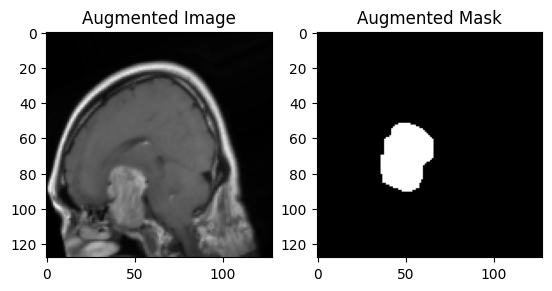

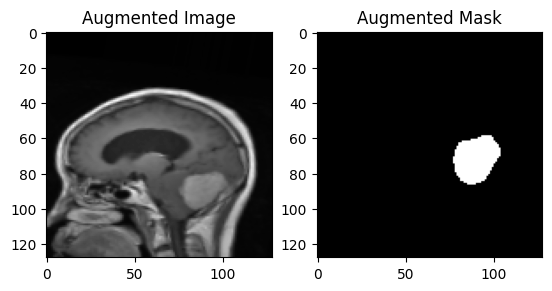

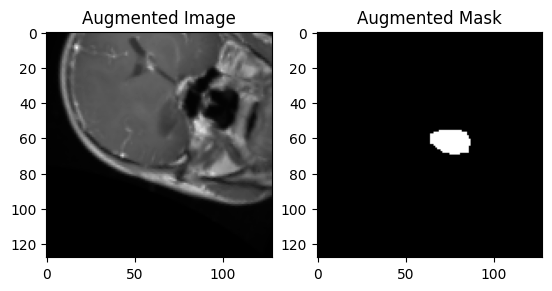

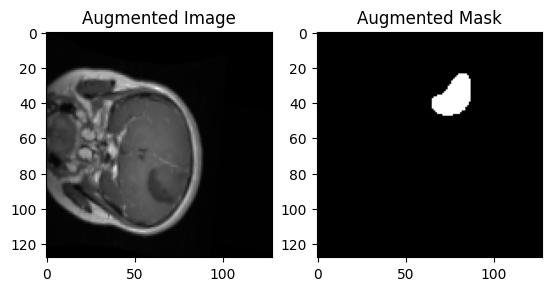

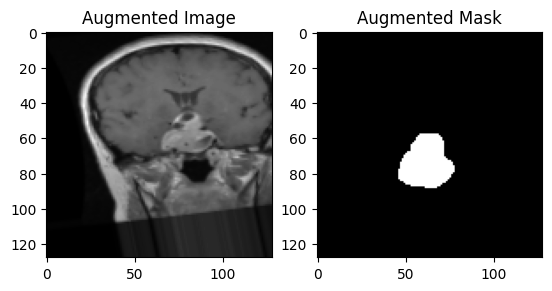

In [14]:
for i in range(5):
    img, mask = next(train_generator)
    plt.subplot(1, 2, 1)
    plt.imshow(img[0].squeeze(), cmap="gray")
    plt.title("Augmented Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0].squeeze(), cmap="gray")
    plt.title("Augmented Mask")
    plt.show()

# **Defining Loss (DICE + Binary Cross Entropy)**

In [15]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * tf.keras.backend.sum(intersection) + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return 1. - score

### bce_dice_loss = binary_crossentropy_loss + dice_loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def focal_loss(y_true, y_pred):
    gamma=2.
    alpha=0.25

    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())

    # Cross entropy
    cross_entropy = -y_true * tf.keras.backend.log(y_pred)

    # Compute focal loss
    loss = alpha * tf.keras.backend.pow(1 - y_pred, gamma) * cross_entropy
    return tf.keras.backend.sum(loss, axis=-1)

# **Model Architecture (Segmentation)**

This architecture is a modified U-Net model designed for image segmentation tasks using a pre-trained MobileNetV2 encoder as the feature extractor. The encoder is used to capture high-level semantic features from input images, while the decoder upscales the features and reconstructs the output mask. This model combines the power of transfer learning (using MobileNetV2 pre-trained on ImageNet) with the flexibility of the U-Net architecture for pixel-level segmentation.

In [16]:
def conv2d_block( input_tensor, n_filters, kernel_size = (3,3), name="contraction"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
             padding='same',activation="relu", name=name+'_1')(input_tensor)

  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
             padding='same',activation="relu",name=name+'_2')(x)
  return x


# Define input dimensions
IMG_DIM = (128, 128, 1)

# Create input tensor
inp = Input(shape=IMG_DIM)

# Adapt grayscale input to RGB (required for pre-trained model)
# Repeat the single channel 3 times
input_rgb = tf.keras.layers.Concatenate()([inp, inp, inp])

# Load pre-trained MobileNetV2 as encoder (without top classification layer)
base_model = MobileNetV2(input_shape=(128, 128, 3), 
                        include_top=False, 
                        weights='imagenet')

# Freeze early layers to prevent overfitting
for layer in base_model.layers[:100]:
    layer.trainable = False

# Extract features from encoder for skip connections
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
]

# Get the output layers for skip connections
layers = [base_model.get_layer(name).output for name in layer_names]

# Create encoder model with multiple outputs for skip connections
encoder_model = Model(inputs=base_model.input, outputs=layers)

# Get encoder features
x = input_rgb
skip_features = encoder_model(x)

# Bottleneck layer - use the last skip feature (deepest)
bottleneck = skip_features[-1]

# Decoder path with skip connections
# Upsampling block 1
up1 = UpSampling2D(size=(2, 2))(bottleneck)
up1 = Conv2D(256, (3, 3), padding='same', activation='relu')(up1)
concat1 = concatenate([up1, skip_features[-2]])
concat1 = Dropout(0.1)(concat1)
conv1 = conv2d_block(concat1, 128, name="expansion_1")

# Upsampling block 2
up2 = UpSampling2D(size=(2, 2))(conv1)
up2 = Conv2D(128, (3, 3), padding='same', activation='relu')(up2)
concat2 = concatenate([up2, skip_features[-3]])
concat2 = Dropout(0.1)(concat2)
conv2 = conv2d_block(concat2, 64, name="expansion_2")

# Upsampling block 3
up3 = UpSampling2D(size=(2, 2))(conv2)
up3 = Conv2D(64, (3, 3), padding='same', activation='relu')(up3)
concat3 = concatenate([up3, skip_features[-4]])
concat3 = Dropout(0.1)(concat3)
conv3 = conv2d_block(concat3, 32, name="expansion_3")

# Upsampling block 4 - go to original image size
up4 = UpSampling2D(size=(2, 2))(conv3)
up4 = Conv2D(32, (3, 3), padding='same', activation='relu')(up4)
conv4 = conv2d_block(up4, 16, name="expansion_4")

# Output layer
out = Conv2D(1, (1, 1), name="output", activation='sigmoid')(conv4)

# Create model
unet = Model(inputs=inp, outputs=out)

# Display model summary
unet.summary()

I0000 00:00:1746191640.134565      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 3)    │              0 │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0],     │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 64, 64, 96),   │        616,256 │ concatenate[0][0]      │
│                           │ (None, 32, 32, 144),   │                │                        │
│                           │ (None, 16, 16, 192),   │                │                        │
│                           │ (None, 8, 8, 576)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 16, 16, 576)    │              0 │ functional[0][3]       │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 256)    │      1,327,360 │ up_sampling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 16, 16, 448)    │              0 │ conv2d[0][0],          │
│ (Concatenate)             │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 448)    │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expansion_1_1 (Conv2D)    │ (None, 16, 16, 128)    │        516,224 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expansion_1_2 (Conv2D)    │ (None, 16, 16, 128)    │        147,584 │ expansion_1_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 32, 32, 128)    │              0 │ expansion_1_2[0][0]    │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ up_sampling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 32, 32, 272)    │              0 │ conv2d_1[0][0],        │
│ (Concatenate)             │                        │                │ functional[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 272)    │              0 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expansion_2_1 (Conv2D)    │ (None, 32, 32, 64)     │        156,736 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expansion_2_2 (Conv2D)    │ (None, 32, 32, 64)     │         36,928 │ expansion_2_1[0][0]    │
├──────────────────────

 Total params: 3,057,169 (11.66 MB)

 Trainable params: 2,677,457 (10.21 MB)

 Non-trainable params: 379,712 (1.45 MB)

## Classification Architecture

The classification task in this project was introduced in the second improvement, where a classification network was added to the pipeline while keeping the segmentation model (U-Net) unchanged. The classification network uses the **EfficientNetB1** architecture, which is known for its superior performance in terms of accuracy and computational efficiency. 

### EfficientNetB1 Model
EfficientNetB1 is a part of the EfficientNet family, a state-of-the-art convolutional neural network (CNN) known for achieving high accuracy with fewer parameters compared to other models, such as ResNet and DenseNet. The model was pre-trained on ImageNet and fine-tuned on the brain tumor dataset.

The architecture is designed to efficiently scale both depth and width of the network, ensuring high performance without unnecessarily increasing computational cost.

### Architecture Details:
1. **Pre-trained EfficientNetB1**: 
   - We used the EfficientNetB1 model with weights pre-trained on ImageNet. 
   - The top layer of EfficientNetB1 was removed to adapt it for our specific classification task.

2. **Global Average Pooling**: 
   - A **GlobalAveragePooling2D** layer was added to reduce the spatial dimensions of the output and obtain a fixed-size feature vector.

3. **Batch Normalization**:
   - **BatchNormalization** was applied to stabilize the learning process by normalizing the activations and reducing internal covariate shift.

4. **Dropout**: 
   - Dropout layers with a 50% rate were added after the dense layers to prevent overfitting during training.

5. **Fully Connected Dense Layers**:
   - A dense layer with **512 units** and **ReLU** activation was added, along with L2 regularization to help avoid overfitting.
   - The output layer consists of **3 units** with a **softmax** activation function, representing the three tumor types: glioma, meningioma, and pituitary tumor.

In [17]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2


effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
# for layer in effnet.layers[:200]:
#     layer.trainable = False
model = effnet.output
model = GlobalAveragePooling2D()(model)
model = BatchNormalization()(model)  # Add BatchNormalization for stabilization
model = Dropout(0.5)(model)
model = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(model)  # L2 regularization in Dense layer
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model) 
classification_model = Model(inputs= effnet.input, outputs=model)

classification_model.summary()
     


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 128, 128, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 128, 128, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 129, 129, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 64, 64, 32)     │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 64, 64, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 64, 64, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 64, 64, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 64, 64, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 64, 64, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 7,237,770 (27.61 MB)

 Trainable params: 7,173,155 (27.36 MB)

 Non-trainable params: 64,615 (252.41 KB)

# **Defining Metrics**

In [18]:
precision = Precision()
recall = Recall()

# Define F1-Score Metric
@register_keras_serializable()
def f1_metric(y_true, y_pred):
    # Calculate Precision and Recall using the already instantiated objects
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    
    # F1 Score calculation
    return 2 * (precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon())

@register_keras_serializable()
def rmse_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure that y_true is of type float32
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


def iou_metric(y_true, y_pred):
    # Flatten tensors and cast them to float32 to ensure matching data types
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))  # Cast y_true to float32
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))  # Cast y_pred to float32

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    # Avoid division by zero and compute IOU
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou


def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best


# **Compiling Model**

In [19]:
unet.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
             loss=bce_dice_loss,
             metrics=[
                 'accuracy',
                 iou_metric,
                 Precision(),                   
                 Recall(),                      
                 f1_metric, 
                 rmse_metric
             ])


# Compile the classification model
classification_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss,
    metrics=['accuracy']
)

# **Availability of GPU**

In [20]:
if tf.config.list_physical_devices('GPU'):
    print("CUDA GPU is available.")
else:
    print("Using CPU.")

CUDA GPU is available.


# **Training Model**

In [21]:
model_checkpoint  = ModelCheckpoint('model_best_checkpoint.keras', save_best_only=True,
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=1, monitor='val_loss',min_lr=1e-6, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

batch_size = 32

hist_segmentation = unet.fit(train_generator,
                epochs=50, 
                validation_data=val_generator,
                verbose=1, 
                callbacks=callback_list)

unet = load_model('model_best_checkpoint.keras', custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':iou_metric, 'f1_metric': f1_metric, 'rmse_metric': rmse_metric}) #or compile = False

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746191664.392066     116 service.cc:148] XLA service 0x7b7358002fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746191664.392840     116 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746191665.908346     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/62 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9478 - f1_metric: 0.0025 - iou_metric: 0.0113 - loss: 1.2940 - precision_1: 0.0020 - recall_1: 0.0025 - rmse_metric: 0.2476 

I0000 00:00:1746191679.016134     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9669 - f1_metric: 0.0150 - iou_metric: 0.0401 - loss: 1.0829 - precision_1: 0.0838 - recall_1: 0.0498 - rmse_metric: 0.1770
Epoch 1: val_loss improved from inf to 1.25617, saving model to model_best_checkpoint.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 53s 377ms/step - accuracy: 0.9668 - f1_metric: 0.0157 - iou_metric: 0.0407 - loss: 1.0813 - precision_1: 0.0854 - recall_1: 0.0517 - rmse_metric: 0.1770 - val_accuracy: 0.9752 - val_f1_metric: 0.1669 - val_iou_metric: 1.5877e-04 - val_loss: 1.2562 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_rmse_metric: 0.1570 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9493 - f1_metric: 0.1804 - iou_metric: 0.1264 - loss: 0.8907 - precision_1: 0.2046 - recall_1: 0.3494 - rmse_metric: 0.1844
Epoch 2: val_loss improved from 1.25617 to 1.06596, saving model to model_best_checkpoint.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9492 - f

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# One-hot encode the classification labels
train_labels_cat = to_categorical(train_labels, num_classes=3)  # One-hot encode for 3 classes
val_labels_cat = to_categorical(val_labels, num_classes=3)      # One-hot encode for 3 classes
test_labels_cat = to_categorical(test_labels, num_classes=3)    # One-hot encode for 3 classes

# Convert NumPy arrays to TensorFlow tensors
X_tensor = tf.convert_to_tensor(X_train)
X_val_tensor = tf.convert_to_tensor(X_val)
X_test_tensor = tf.convert_to_tensor(X_test)

# Resize images to a smaller resolution before passing to the model
X_tensor = tf.image.resize(X_tensor, (128, 128))  # Resize images to 128x128
X_val_tensor = tf.image.resize(X_val_tensor, (128, 128))      # Resize validation images
X_test_tensor = tf.image.resize(X_test_tensor, (128, 128))      # Resize validation images



# Now convert grayscale to RGB (3 channels)
X_train_rgb = tf.image.grayscale_to_rgb(X_tensor)  # Convert grayscale to RGB (None, 128, 128, 1) -> (None, 128, 128, 3)
X_val_rgb = tf.image.grayscale_to_rgb(X_val_tensor)  # Convert validation set similarly
X_test_rgb = tf.image.grayscale_to_rgb(X_test_tensor)  # Convert test set similarly

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=10,         # Random rotations in the range of 10 degrees
    width_shift_range=0.2,     # Random horizontal shift
    height_shift_range=0.2,    # Random vertical shift
    horizontal_flip=True,      # Random horizontal flip
)

# Define ImageDataGenerator for validation (without augmentation)
validation_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

# Assuming X_train_rgb, Y_train_classification are your training data and labels
# Flow data from numpy arrays to the generator
train_generator_classification = datagen.flow(X_train_rgb, train_labels_cat, batch_size=32)
validation_generator_classification = validation_datagen.flow(X_val_rgb, val_labels_cat, batch_size=32)
test_generator_classification = test_datagen.flow(X_test_rgb, test_labels_cat, batch_size=32)


# Define callbacks
model_checkpoint = ModelCheckpoint('classification_best_checkpoint.keras', save_best_only=True,
                                   monitor='val_accuracy', mode="auto", verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode="auto", verbose=1)

reduceLR = ReduceLROnPlateau(patience=4, verbose=1, monitor='val_accuracy', min_lr=1e-6, mode="auto")

# Combine callbacks into a list
callback_list = [early_stopping, reduceLR, model_checkpoint]

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(train_labels_cat, axis=1)), y=np.argmax(test_labels_cat, axis=1))
class_weight_dict = dict(enumerate(class_weights))

# Train the classification model
hist_classification = classification_model.fit(
    train_generator_classification,  # Training data generator with augmentation
    epochs=50,
    validation_data=validation_generator_classification,  # Validation data generator
    verbose=1,
    class_weight=class_weight_dict,  # Apply class weights
    callbacks=callback_list
)

# After training, load the best model based on validation loss
classification_model = load_model('classification_best_checkpoint.keras', custom_objects={'focal_loss': focal_loss, 'f1_metric': f1_metric})


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.6912 - loss: 3.7370
Epoch 1: val_accuracy improved from -inf to 0.46640, saving model to classification_best_checkpoint.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 118s 784ms/step - accuracy: 0.6913 - loss: 3.7367 - val_accuracy: 0.4664 - val_loss: 5.7208 - learning_rate: 1.0000e-05
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7470 - loss: 3.6589
Epoch 2: val_accuracy did not improve from 0.46640
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.7469 - loss: 3.6587 - val_accuracy: 0.3279 - val_loss: 6.2321 - learning_rate: 1.0000e-05
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7241 - loss: 3.6066
Epoch 3: val_accuracy did not improve from 0.46640
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.7240 - loss: 3.6065 - val_accuracy: 0.4664 - val_loss: 5.6280 - learning_rate: 1.0000e-05
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7287 - loss: 3.5545
Epoch 4: val_accuracy 

# **Visualizing Performance of Model** 

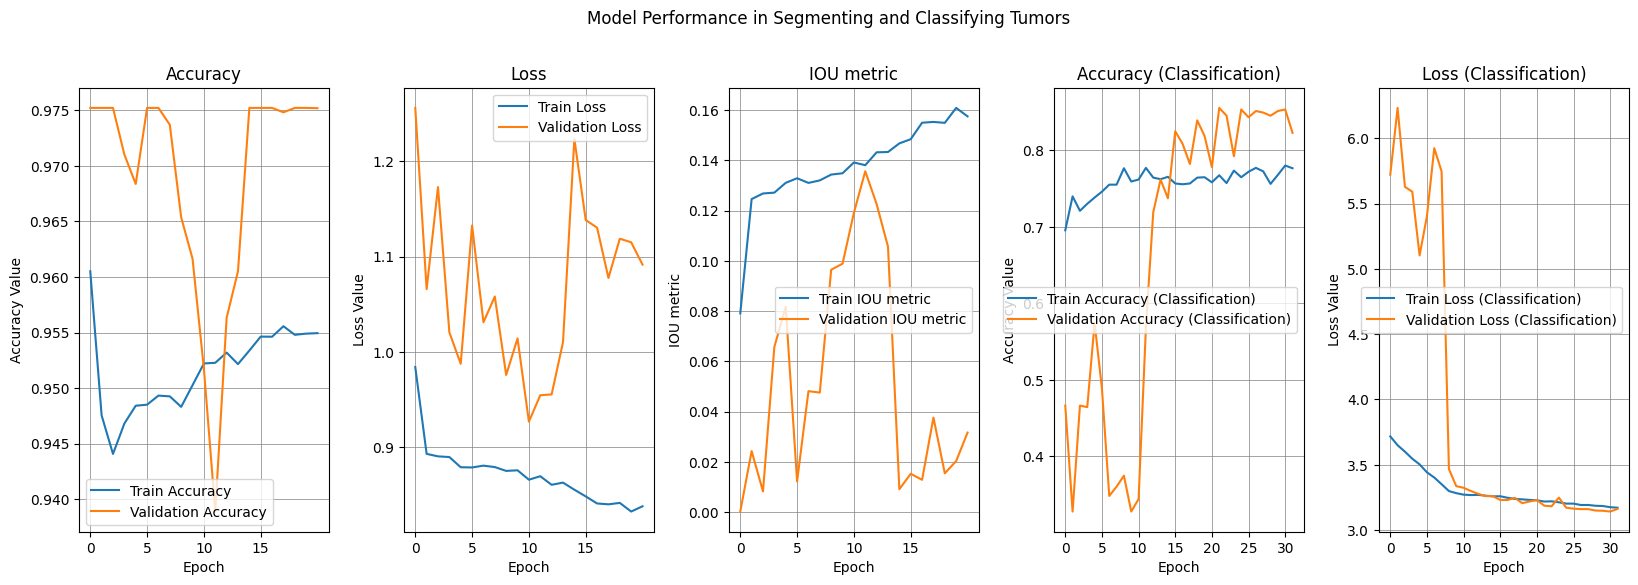

Metric                   Training Avg        Validation Avg      
-----------------------------------------------------------------
Precision (Segmentation) 0.2219              0.1164              
Recall (Segmentation)    0.3620              0.0834              
F1-Score (Segmentation)  0.2320              0.2386              
RMSE (Segmentation)      0.1814              0.1645              
Accuracy (Segmentation)  0.9517              0.9690              
Loss (Segmentation       0.8706              1.0694              
Accuracy (Classification)0.7584              0.6701              
Loss (Classification)    3.3036              3.8376              


In [28]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 6))
t = f.suptitle('Model Performance in Segmenting and Classifying Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist_segmentation.epoch
epoch_list_classification = hist_classification.epoch

ax1.plot(epoch_list, hist_segmentation.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist_segmentation.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist_segmentation.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist_segmentation.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist_segmentation.history['iou_metric'], label='Train IOU metric')
ax3.plot(epoch_list, hist_segmentation.history['val_iou_metric'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

ax4.plot(epoch_list_classification, hist_classification.history['accuracy'], label='Train Accuracy (Classification)')
ax4.plot(epoch_list_classification, hist_classification.history['val_accuracy'], label='Validation Accuracy (Classification)')
ax4.set_xticks(np.arange(0, epoch_list_classification[-1], 5))
ax4.set_ylabel('Accuracy Value');ax4.set_xlabel('Epoch');ax4.set_title('Accuracy (Classification)')
ax4.legend(loc="best");ax4.grid(color='gray', linestyle='-', linewidth=0.5)
ax5.plot(epoch_list_classification, hist_classification.history['loss'], label='Train Loss (Classification)')
ax5.plot(epoch_list_classification, hist_classification.history['val_loss'], label='Validation Loss (Classification)')
ax5.set_xticks(np.arange(0, epoch_list_classification[-1], 5))
ax5.set_ylabel('Loss Value');ax5.set_xlabel('Epoch');ax5.set_title('Loss (Classification)')
ax5.legend(loc="best");ax5.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()



# Retrieve dynamic metric names
precision_metrics = [metric for metric in hist_segmentation.history.keys() if 'precision' in metric]
recall_metrics = [metric for metric in hist_segmentation.history.keys() if 'recall' in metric]

# Calculate mean precision for training and validation
mean_precision_training = np.mean(hist_segmentation.history[precision_metrics[0]])  # Use first precision metric
mean_precision_validation = np.mean(hist_segmentation.history['val_' + precision_metrics[0]])  # Use corresponding validation metric

# Calculate mean recall for training and validation
mean_recall_training = np.mean(hist_segmentation.history[recall_metrics[0]])  # Use first recall metric
mean_recall_validation = np.mean(hist_segmentation.history['val_' + recall_metrics[0]])  # Use corresponding validation metric

mean_f1_metric_training = np.mean(hist_segmentation.history['f1_metric'])
mean_f1_metric_validation = np.mean(hist_segmentation.history['val_f1_metric'])

mean_rmse_metric_training = np.mean(hist_segmentation.history['rmse_metric'])
mean_rmse_metric_validation = np.mean(hist_segmentation.history['val_rmse_metric'])

mean_accuracy_training = np.mean(hist_segmentation.history['accuracy'])
mean_accuracy_validation = np.mean(hist_segmentation.history['val_accuracy'])

mean_loss_training = np.mean(hist_segmentation.history['loss'])
mean_loss_validation = np.mean(hist_segmentation.history['val_loss'])

mean_accuracy_training_c = np.mean(hist_classification.history['accuracy'])
mean_accuracy_validation_c = np.mean(hist_classification.history['val_accuracy'])

mean_loss_training_c = np.mean(hist_classification.history['loss'])
mean_loss_validation_c = np.mean(hist_classification.history['val_loss'])


print(f"{'Metric':<25}{'Training Avg':<20}{'Validation Avg':<20}")
print("-" * 65)

print(f"{'Precision (Segmentation)':<25}{mean_precision_training:<20.4f}{mean_precision_validation:<20.4f}")
print(f"{'Recall (Segmentation)':<25}{mean_recall_training:<20.4f}{mean_recall_validation:<20.4f}")
print(f"{'F1-Score (Segmentation)':<25}{mean_f1_metric_training:<20.4f}{mean_f1_metric_validation:<20.4f}")
print(f"{'RMSE (Segmentation)':<25}{mean_rmse_metric_training:<20.4f}{mean_rmse_metric_validation:<20.4f}")
print(f"{'Accuracy (Segmentation)':<25}{mean_accuracy_training:<20.4f}{mean_accuracy_validation:<20.4f}")
print(f"{'Loss (Segmentation':<25}{mean_loss_training:<20.4f}{mean_loss_validation:<20.4f}")
print(f"{'Accuracy (Classification)':<25}{mean_accuracy_training_c:<20.4f}{mean_accuracy_validation_c:<20.4f}")
print(f"{'Loss (Classification)':<25}{mean_loss_training_c:<20.4f}{mean_loss_validation_c:<20.4f}")


# **Evaluating Model on Testing Dataset**

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9516 - f1_metric: 0.2559 - iou_metric: 0.1114 - loss: 0.9403 - precision_1: 0.1789 - recall_1: 0.2882 - rmse_metric: 0.1856
Test Loss: 0.9452
Test Accuracy: 95.0656%
Test IoU: 0.1138
Test Precision: 0.1792
Test Recall: 0.2767
Test F1 Score: 0.2557
Test RMSE: 0.1876
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.8483 - loss: 3.1915
Test Classification Loss: 3.188
Test Classification Accuracy: 86.46%
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 420ms/step


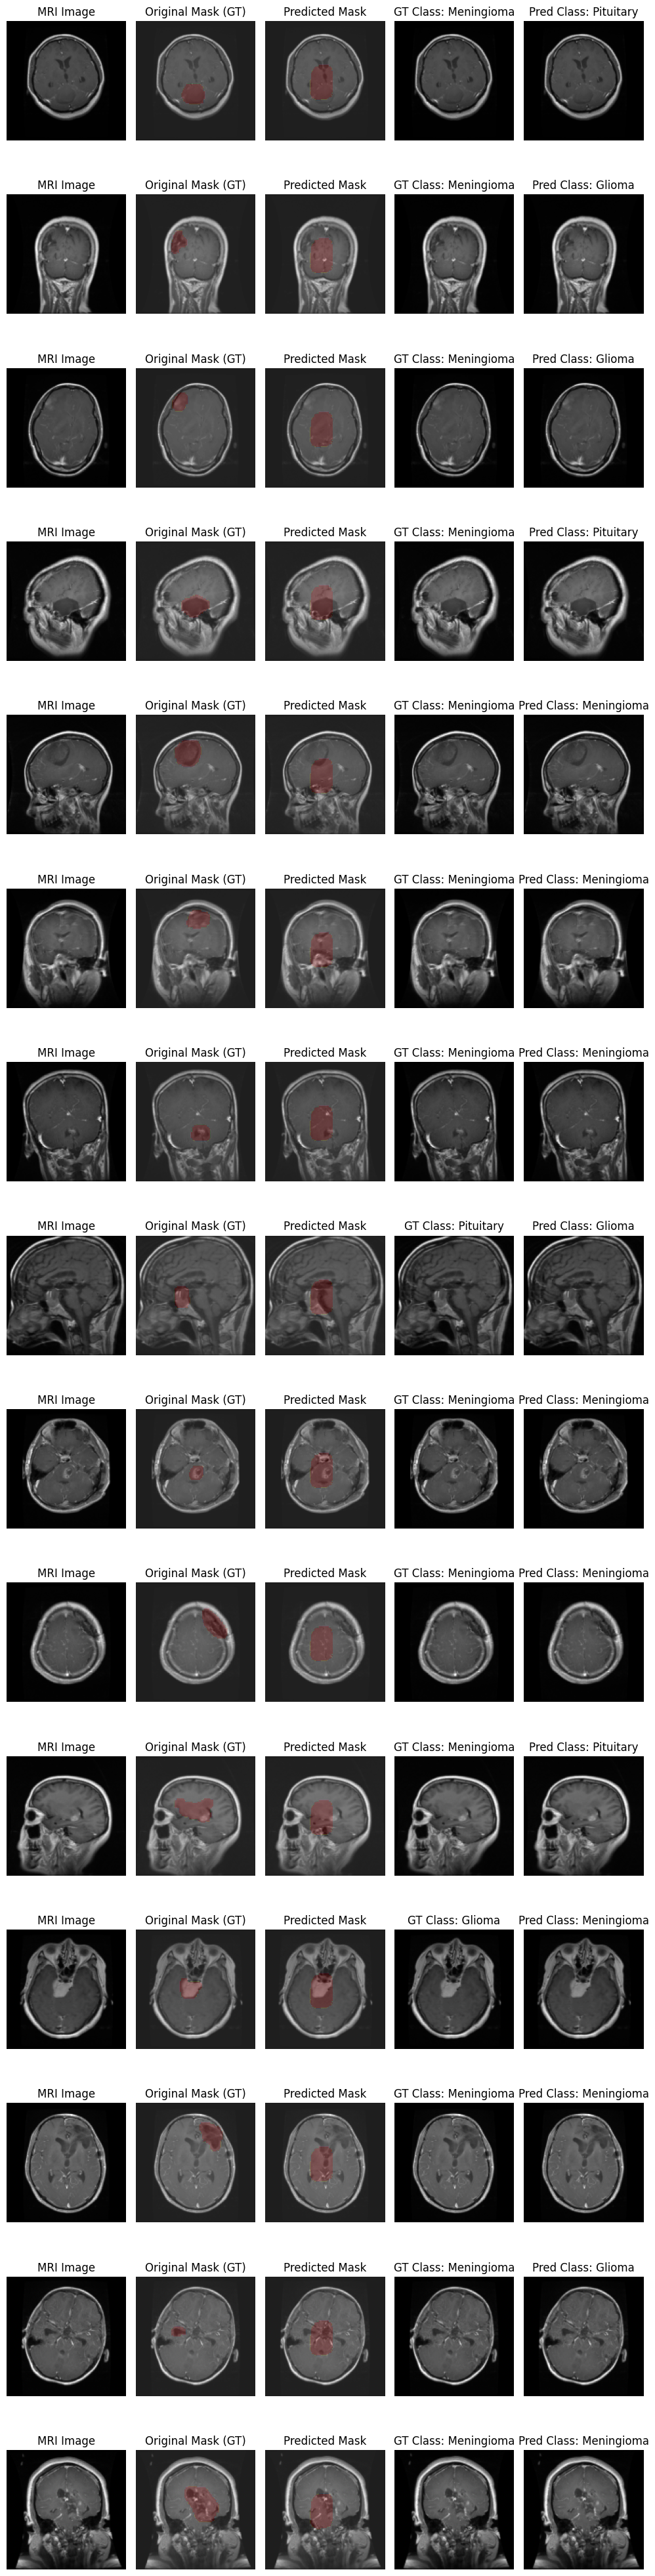

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Set the threshold for segmentation prediction
THRESHOLD = 0.2

# Evaluate the segmentation model using the generator
segmentation_results = unet.evaluate(test_generator, verbose=1)

# Print the segmentation evaluation results
test_loss, test_accuracy, test_iou, test_precision, test_recall, test_f1, test_rmse = segmentation_results
print(f"Test Loss: {round(test_loss, 4)}")
print(f"Test Accuracy: {round(test_accuracy*100, 4)}%")
print(f"Test IoU: {round(test_iou, 4)}")
print(f"Test Precision: {round(test_precision, 4)}")
print(f"Test Recall: {round(test_recall, 4)}")
print(f"Test F1 Score: {round(test_f1, 4)}")
print(f"Test RMSE: {round(test_rmse, 4)}")

# Make predictions for segmentation using the generator
predicted_mask = (unet.predict(test_generator, verbose=1) > THRESHOLD) * 1

# Evaluate the classification model using the generator
classification_results = classification_model.evaluate(test_generator_classification, verbose=1)

# Print the classification evaluation results
test_class_loss, test_class_accuracy = classification_results
print(f"Test Classification Loss: {round(test_class_loss, 4)}")
print(f"Test Classification Accuracy: {round(test_class_accuracy*100, 4)}%")

# Make predictions for classification using the generator
predicted_classes = np.argmax(classification_model.predict(test_generator_classification, verbose=1), axis=1)

# Initialize temp as an array of ones with the same shape as your masks (128, 128, 1)
temp = np.ones_like(Y_test[0])  # Assuming Y_test is a numpy array with shape (batch_size, 128, 128, 1)

# Plotting the results
plt.figure(figsize=(10, 40))
i = 1
total = 15  # You can change this number to display more samples

# Loop through random samples from the test data
for idx in np.random.randint(0, high=X_test.shape[0], size=total):
    # MRI Image
    plt.subplot(total, 5, i)
    i += 1
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.title("MRI Image")
    plt.axis('off')

    # Original Ground Truth Mask
    plt.subplot(total, 5, i)
    i += 1
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.imshow(np.squeeze(temp - Y_test[idx], axis=-1), alpha=0.2, cmap='Set1')
    plt.title("Original Mask (GT)")
    plt.axis('off')

    # Predicted Mask (Segmentation)
    plt.subplot(total, 5, i)
    i += 1
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.imshow(np.squeeze(temp - predicted_mask[idx], axis=-1), alpha=0.2, cmap='Set1')
    plt.title("Predicted Mask")
    plt.axis('off')

    # Ground Truth Class (Classification)
    plt.subplot(total, 5, i)
    i += 1
    gt_class = np.argmax(test_labels_cat[idx])  # Get ground truth class
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.title(f"GT Class: {['Glioma', 'Meningioma', 'Pituitary'][gt_class]}")
    plt.axis('off')

    # Predicted Class (Classification)
    plt.subplot(total, 5, i)
    i += 1
    predicted_class = predicted_classes[idx]  # Get predicted class
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.title(f"Pred Class: {['Glioma', 'Meningioma', 'Pituitary'][predicted_class]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
